# Setup

## Libraries

In [1]:
import math, torch, torchrl

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensordict import TensorDict, TensorDictBase
from tensordict.nn import TensorDictModule
from tensordict.utils import NestedKey
from torch import Tensor
from torch.nn.attention import SDPBackend, sdpa_kernel
from torch.utils.cpp_extension import load_inline
from torchrl.collectors import SyncDataCollector
from torchrl.data import (
    Binary,
    Categorical,
    Composite,
    LazyTensorStorage,
    ReplayBuffer,
    TensorSpec,
    UnboundedContinuous
)
from torchrl.data.replay_buffers import SamplerWithoutReplacement
from torchrl.envs import EnvBase, SerialEnv
from torchrl.envs.transforms import ActionMask, TransformedEnv
from torchrl.modules import MaskedCategorical, ProbabilisticActor
from torchrl.objectives import SoftUpdate
from torchrl.objectives.sac import DiscreteSACLoss

## Constants

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu' # Device for training
BATCH_SIZE = 32 # Batch size for training
LR = 1e-4 # Learning rate for the optimizer
WEIGHT_DECAY = 1e-4 # Weight decay for the optimizer

MAX_BOARD_SIZE = 5 # Maximum board size for the Hex game
N_CHANNEL = 4 # Number of channels for the observation (Red, Blue, Playable Mask, Swapable Indicator)
BOARD_SIZE = 5 # Size of the Hex board (board_size x board_size)
SWAP_RULE = True # Whether to use the swap rule in the Hex game

BUFFER_SIZE = 100_000 # Size of the replay buffer
N_FRAMES_PER_BATCH = 128 # Number of frames to store in the replay buffer per episode
STORAGE_DEVICE = DEVICE  # Device for storing the replay buffer data
# STORAGE_DEVICE = 'cpu' # Device for storing the replay buffer data

# Training Configuration
TOTAL_FRAMES = 1_000_000 # Total training frames
WARMUP_FRAMES = 5_000 # Random exploration frames before training
OPTIMIZATION_STEPS = 10 # UTD Ratio: gradient updates per collection
TAU = 0.005 # Soft update coefficient for target network
LOG_INTERVAL = 100 # Log and evaluate every N iterations
EVAL_GAMES = 200 # Number of games for evaluation

MODEL_PARAMS = {
    "conv_layers": [(32, 3)],
    "n_encoder_layers": 1,
    "d_input": N_CHANNEL,
    "n_heads": 4,
    "d_ff": 128,
    "dropout": 0.01,
    "output_flatten": False,
}

# Environment

## Base Environment

In [3]:
class HexEnv(EnvBase):
    """Hex game environment for reinforcement learning."""
    N_ENV_CHANNELS = 5  # Red (P0), Blue (P1), Current Player, Playable Mask, Swapable Indicator
    """
    Args:
        board_size: Size of the game board (board_size x board_size)
        max_board_size: Maximum board size for padding
        swap_rule: Whether to enable the swap rule (default: True)
        device: Device for tensor computation (default: 'cpu')
    """
    def __init__(
        self, 
        board_size: int,
        max_board_size: int,
        swap_rule: bool = True,
        device: torch.device = torch.device('cpu')
    ):
        # Assertions
        assert board_size >= 1, "Board size must be greater than or equal to 1."
        assert board_size <= max_board_size, "Board size must be less than or equal to max Board size."

        super().__init__(device=device, spec_locked=False)

        # Parameters
        self.board_size: int = board_size
        self.max_board_size: int = max_board_size
        self.n_channel: int = self.N_ENV_CHANNELS
        self.swap_rule: bool = swap_rule

        # Create shape variables
        self.board_shape: torch.Size = torch.Size(
            (self.max_board_size, self.max_board_size)
        ) # (max_board_size, max_board_size)

        # Valid board mask
        self.valid_board: Tensor = torch.zeros(
            self.board_shape, 
            dtype=torch.bool, 
            device=self.device
        ) # (max_board_size, max_board_size)
        self.valid_board[:self.board_size, :self.board_size] = 1

        # Create private spec variables
        self.observation_spec = Composite({
            "observation": Binary(
                shape=self.board_shape + (self.n_channel,),
                # (max_board_size, max_board_size, n_channel)
                device=self.device,
                dtype=torch.float32
            ),
            "action_mask": Binary(
                shape=(self.max_board_size ** 2,),
                # (max_board_size ** 2,)
                device=self.device,
                dtype=torch.bool
            )
        })
        self.action_spec = Categorical(
            n=self.max_board_size ** 2,
            # Number of discrete actions for each side of the board
            device=self.device,
            dtype=torch.long
        )
        self.reward_spec = UnboundedContinuous(
            shape=(1,),
            device=device,
            dtype=torch.float32
        ) # Reward for both players

    def _reset(self, tensordict: TensorDict | None = None, **kwargs) -> TensorDict:
        # Initialize a fresh board
        board: Tensor = torch.full((self.max_board_size, self.max_board_size), -1, dtype=torch.long, device=self.device) # -1: empty, 0: player 0 (red), 1: player 1 (blue)
        current_player: int = 0 # 0: player 0 (red), 1: player 1 (blue)
        done: Tensor = torch.tensor(False, dtype=torch.bool, device=self.device) # Game not done

        # Create fresh observation, mask, done, reward
        fresh_action: Tensor = torch.tensor([0], dtype=torch.long, device=self.device) # Placeholder action
        fresh_observation: Tensor = torch.zeros((self.max_board_size, self.max_board_size, self.n_channel), dtype=torch.float32, device=self.device) # (max_board_size, max_board_size, n_channel)
        fresh_observation[..., 0] = (board == 0).float() # Red pieces channel
        fresh_observation[..., 1] = (board == 1).float() # Blue pieces channel
        fresh_observation[..., 2] = current_player # 0: player 0 (red), 1: player 1 (blue)
        fresh_observation[..., 3] = self.valid_board.clone().float() # (max_board_size, max_board_size) Playable board mask
        fresh_observation[..., 4] = self.swap_rule * 1.0 # Swap rule indicator channel
        fresh_action_mask: Tensor = self.valid_board.clone().bool().flatten() # (max_board_size ** 2,) Valid move mask
        fresh_done: Tensor = done # Not done

        fresh_tensordict: TensorDict = TensorDict({
            "action": fresh_action,
            "observation": fresh_observation,
            "action_mask": fresh_action_mask,
            "done": fresh_done
        }, device=self.device)
        return fresh_tensordict

    def _step(self, tensordict: TensorDict, **kwargs) -> TensorDict:
        action: Tensor = tensordict.get("action").clone() # Scalar tensor representing the action
        observation: Tensor = tensordict.get("observation").clone() # (max_board_size, max_board_size, n_channel)

        # Extract action details
        index = int(action.item())
        row, col = divmod(index, self.max_board_size)

        # Extract observation details
        current_player = int(observation[0, 0, 2].item())
        swap_available = bool(observation[0, 0, 4].item())

        board_red, board_blue = observation[..., 0], observation[..., 1]
        total_stones = int((board_red + board_blue).sum().item())

        if not (0 <= row < self.max_board_size and 0 <= col < self.max_board_size):
            raise ValueError(f"Invalid action {index}: out of bounds (row={row}, col={col}).")
        if not self.valid_board[row, col]:
            raise ValueError(f"Invalid action {index}: outside playable area (row={row}, col={col}).")
    
        cell_empty = (board_red[row, col] == 0) and (board_blue[row, col] == 0)
        swap_action = (
            self.swap_rule
            and swap_available
            and current_player == 1
            and total_stones == 1
            and board_red[row, col] == 1
            and board_blue[row, col] == 0
        ) # Player 1 (blue) can swap only on their first move

        if not (cell_empty or swap_action):
            raise ValueError(f"Invalid action {index}: cell occupied and swap not permitted.")

        # Create next observation
        next_observation: Tensor = observation.clone()
        if swap_action:
            next_observation[..., 0], next_observation[..., 1] = next_observation[..., 1].clone(), next_observation[..., 0].clone()
        else:
            next_observation[row, col, current_player] = 1.0

        if self._check_done(next_observation, current_player):
            next_reward = torch.tensor([1.0], dtype=torch.float32, device=self.device)
            next_done = torch.tensor(True, dtype=torch.bool, device=self.device)
        else:
            next_reward = torch.tensor([0.0], dtype=torch.float32, device=self.device)
            next_done = torch.tensor(False, dtype=torch.bool, device=self.device)
            current_player = 1 - current_player

        swap_available_next = bool(self.swap_rule and (total_stones == 0) and not next_done) # Update swap availability for next state
        next_observation[..., 2] = float(current_player)
        next_observation[..., 4] = float(swap_available_next)

        empty_mask = (next_observation[..., 0] == 0) & (next_observation[..., 1] == 0) & self.valid_board
        next_action_mask = empty_mask.flatten()
        if swap_available_next:
            next_action_mask[index] = True

        next_tensordict: TensorDict = TensorDict({
            "observation": next_observation,
            "action_mask": next_action_mask,
            "done": next_done,
            "reward": next_reward
        }, device=self.device)
        return next_tensordict

    def _check_done(self, observation: Tensor, current_player: int) -> bool:
        def dfs(board, start_positions, target_condition, directions):
            visited = torch.zeros((self.board_size, self.board_size), dtype=torch.bool)
            for start in start_positions:
                if board[start] == 1 and not visited[start]:
                    stack = [start]
                    visited[start] = True
                    while stack:
                        r, c = stack.pop()
                        if target_condition(r, c):
                            return True
                        for dr, dc in directions:
                            nr, nc = r + dr, c + dc
                            if 0 <= nr < self.board_size and 0 <= nc < self.board_size and board[nr, nc] == 1 and not visited[nr, nc]:
                                visited[nr, nc] = True
                                stack.append((nr, nc))
            return False

        directions = [(-1,0), (1,0), (0,-1), (0,1), (1,-1), (-1,1)] # 6 possible directions in a hex grid
        board_state = observation[:self.board_size, :self.board_size, :]
        # Use DFS to check if player 0 (red) has connected top to bottom
        if current_player == 0:
            board = board_state[..., 0] # Shape (board_size, board_size) # Player 0 pieces
            start_positions = [(0, col) for col in range(self.board_size)]
            target_condition = lambda r, c: r == self.board_size - 1
            if dfs(board, start_positions, target_condition, directions):
                return True

        # Use DFS to check if player 1 (blue) has connected left to right
        else:
            board = board_state[..., 1] # Shape (board_size, board_size) # Player 1 pieces
            start_positions = [(row, 0) for row in range(self.board_size)]
            target_condition = lambda r, c: c == self.board_size - 1
            if dfs(board, start_positions, target_condition, directions):
                return True

        return False # No winner yet

    def _set_seed(self, seed: int) -> None:
        np.random.seed(seed)
        torch.manual_seed(seed)

[0,0] [0,1] [0,2] [0,3]  ← Player 0 bắt đầu
  [1,0] [1,1] [1,2] [1,3]
    [2,0] [2,1] [2,2] [2,3]
      [3,0] [3,1] [3,2] [3,3]  ← Player 0 kết thúc
        ↑                      ↑
    Player 1                Player 1
    bắt đầu               kết thúc

In [4]:
torch.cuda.is_available()

True

## Test Environment

In [5]:
create_hex_env = lambda: HexEnv(board_size=BOARD_SIZE, max_board_size=MAX_BOARD_SIZE, swap_rule=SWAP_RULE, device=STORAGE_DEVICE)
serial_env = TransformedEnv(
    SerialEnv(
        num_workers=1,
        create_env_fn=create_hex_env
    ),
    ActionMask()
)
# serial_env = TransformedEnv(
#     HexEnv(
#         board_size=BOARD_SIZE,
#         max_board_size=MAX_BOARD_SIZE,
#         device=STORAGE_DEVICE
#     ),
#     ActionMask()
# )

r = serial_env.rollout(100, break_when_any_done=False)
r["action"].to(dtype=torch.int)

tensor([[17, 19,  6, 18, 10,  4,  0,  2, 23, 22,  7, 11, 21, 15,  8, 16, 13,  1,
         12,  9,  5,  2,  8, 22, 12, 15,  0, 16,  5, 20, 24,  1, 17, 11,  6, 14,
          3,  4, 10, 13,  9, 19,  7, 11, 22,  6, 24,  2, 17, 14, 16, 13, 18, 21,
          1, 15,  5, 10,  9,  4, 19,  8,  3,  7, 12, 20,  0,  7, 24,  1,  2,  3,
         23,  8, 21, 17,  9, 16, 20, 18,  5, 19, 11, 15, 20,  3, 10, 22, 18,  1,
         14,  7,  2,  0, 19, 15, 21, 17, 11, 23]], device='cuda:0',
       dtype=torch.int32)

# Policy

## Custom Sub-modules

In [6]:
class HexConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size: int = 3, bias: bool = True):
        super(HexConv2d, self).__init__()
        assert kernel_size % 2 == 1 and kernel_size > 0, "kernel_size must be odd and positive."

        stride, padding = 1, kernel_size // 2  # To maintain spatial dimensions
        mask = self._create_hex_mask(kernel_size)

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.register_buffer('mask', mask) # (k, k), requires_grad=False to keep it fixed

    @staticmethod
    def _create_hex_mask(kernel_size: int) -> Tensor:
        assert kernel_size % 2 == 1 and kernel_size > 0, "kernel_size must be odd and positive."

        mask = torch.zeros((kernel_size, kernel_size), dtype=torch.float32)
        center = kernel_size // 2

        for r in range(kernel_size): # Row index
            for c in range(kernel_size): # Column index
                # Using axial distance for a vertically oriented hex grid
                # mapped to an offset coordinate system in the kernel.
                # (r, c) are kernel indices, (dr, dc) are relative to center.
                dr, dc = r - center, c - center
                chebyshev_distance = max(abs(dr), abs(dc), abs(dr + dc))

                if chebyshev_distance <= center: # Inside or on the hexagon
                    mask[r, c] = 1.0

        return mask # (kernel_size, kernel_size)

    def forward(self, x: Tensor) -> Tensor:
        # 1. Tạo trọng số đã mask (Soft masking)
        # Phép nhân '*' tạo ra tensor mới, KHÔNG sửa in-place trọng số gốc.
        # Gradient vẫn truyền ngược qua đây bình thường, các vị trí mask=0 sẽ có grad=0.
        masked_weight = self.conv.weight * self.mask
        
        # 2. Dùng functional conv2d thay vì self.conv(x)
        # Chúng ta truyền masked_weight vào đây.
        x = F.conv2d(
            input=x,
            weight=masked_weight,
            bias=self.conv.bias,
            stride=self.conv.stride,
            padding=self.conv.padding,
            dilation=self.conv.dilation,
            groups=self.conv.groups
        )
        return x


class SkipConnection(nn.Module):
    def __init__(self, adjust_input: nn.Module, original_input: nn.Module = nn.Identity()):
        super(SkipConnection, self).__init__()
        self.adjust_input = adjust_input
        self.original_input = original_input

    def forward(self, x: Tensor) -> Tensor:
        return self.adjust_input(x) + self.original_input(x)


class TriAxialPositionalEmbedding(nn.Module):
    def __init__(self, d_model: int):
        """
        Args:
            d_model: Kích thước channel của input (C). Phải là số chẵn.
        """
        super().__init__()
        assert d_model % 2 == 0, "d_model (C) phải là số chẵn để tính sin/cos."

        # Pre-compute div_term cho sinusoidal
        # Lưu ý: arange(0, d_model, 2) tạo ra d_model/2 phần tử
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        self.d_model = d_model
        self.register_buffer('div_term', div_term)

    def _get_1d_sinusoidal(self, coords: Tensor) -> Tensor:
        """
        Tạo sinusoidal embedding cho một trục toạ độ.
        Args:
            coords: Tensor chứa giá trị toạ độ (số nguyên hoặc thực), shape (H, W)
        Returns:
            Tensor embedding, shape (H, W, d_model)
        """
        # Mở rộng chiều cuối để tính toán: (H, W, 1)
        coords = coords.unsqueeze(-1).float()
        
        # div_term có shape (d_model/2,)
        # phase = coords * div_term -> Shape (H, W, d_model/2)
        phase = coords * self.div_term
        
        # Tính sin và cos riêng biệt
        sin_part = torch.sin(phase) # (H, W, d_model/2)
        cos_part = torch.cos(phase) # (H, W, d_model/2)
        
        # --- FIX LỖI VMAP Ở ĐÂY ---
        # Thay vì gán in-place (pe[..., 0::2] = ...), ta dùng stack và flatten.
        # 1. Stack lại ở chiều cuối cùng: (H, W, d_model/2, 2)
        #    Tại vị trí cuối: [sin, cos], [sin, cos], ...
        val = torch.stack([sin_part, cos_part], dim=-1)
        
        # 2. Flatten 2 chiều cuối để trộn lại thành (H, W, d_model)
        #    Kết quả sẽ là: sin, cos, sin, cos... đúng thứ tự chẵn lẻ
        pe = val.flatten(-2, -1)
        
        return pe

    def forward(self, x: Tensor) -> Tensor:
        # ... (Giữ nguyên phần logic forward cũ) ...
        N, H, W, C = x.shape
        assert C == self.d_model, f"Input channel {C} không khớp với d_model khởi tạo {self.d_model}"

        device = x.device

        rows = torch.arange(H, device=device, dtype=torch.float)
        cols = torch.arange(W, device=device, dtype=torch.float)
        
        r_grid, q_grid = torch.meshgrid(rows, cols, indexing='ij')

        s_grid = -q_grid - r_grid

        pe_q = self._get_1d_sinusoidal(q_grid)
        pe_r = self._get_1d_sinusoidal(r_grid)
        pe_s = self._get_1d_sinusoidal(s_grid)

        full_pe = (pe_q + pe_r + pe_s) / math.sqrt(3)

        return full_pe.unsqueeze(0)

## Base Model

In [7]:
class HexModel(nn.Module):
    def __init__(self, 
                 conv_layers: list[tuple[int, int]],
                 n_encoder_layers: int,
                 d_input: int,
                 n_heads: int = 8,
                 d_ff: int = 2048,
                 dropout: float = 0.1,
                 output_flatten: bool = True):
        """Args:
            conv_layers: List of tuples (out_channels, kernel_size) for each conv layer.
                Note that, in_channels is inferred from the previous layer's out_channels (d_input for the first layer).
            n_encoder_layers: Number of transformer encoder layers.
            d_input: Dimension of input features to the transformer.
            n_heads: Number of attention heads in the transformer.
            d_ff: Dimension of the feedforward network in the transformer.
            dropout: Dropout rate.
        """
        super(HexModel, self).__init__()
        self.output_flatten = output_flatten
        self.d_encoder: int = conv_layers[-1][0] # Last conv layer's out_channels as d_model
        self.conv = nn.Sequential(*[
            SkipConnection(
                nn.Sequential(
                    HexConv2d(conv_layers[i-1][0] if i > 0 else d_input, conv_layers[i][0], conv_layers[i][1], bias=False),
                    nn.GroupNorm(num_groups=4, num_channels=conv_layers[i][0]),
                    nn.GELU(),
                    HexConv2d(conv_layers[i][0], conv_layers[i][0], conv_layers[i][1], bias=False),
                    nn.GroupNorm(num_groups=4, num_channels=conv_layers[i][0]),
                ),
                nn.Identity() if (i > 0 and conv_layers[i][0] == conv_layers[i-1][0]) # Skip connection (identity)
                else nn.Sequential(
                    nn.Conv2d(conv_layers[i-1][0] if i > 0 else d_input, conv_layers[i][0], 1), # Combine with Conv2d (kernel_size = 1) for channel adjustment
                    nn.GroupNorm(num_groups=4, num_channels=conv_layers[i][0]),
                )
            )
            for i in range(len(conv_layers))
        ])
        self.positional_embedding = TriAxialPositionalEmbedding(self.d_encoder)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=self.d_encoder,
                nhead=n_heads,
                dim_feedforward=d_ff,
                dropout=dropout,
                activation='gelu',
                batch_first=True
            ),
            num_layers=n_encoder_layers
        )
        self.projection = nn.Linear(self.d_encoder, 1) # Đầu ra cho Actor (logits)/Critic (Q-value)

    def forward(self, x: Tensor) -> Tensor:
        """Args:
            x: Input tensor of shape (N, H, W, C) where
               N = batch size, H = height, W = width, C = channels (d_input).
            Returns: Tensor of shape (N, H, W) with Q-values for each position.
        """
        # Reshape input to (N, C, H, W) for Conv2d
        if len(x.shape) == 3:
            x = x.unsqueeze(0)  # Add batch dimension if missing
        elif len(x.shape) != 4:
            raise ValueError(f"Input tensor x must have shape (N, H, W, C) or (H, W, C), but got {x.shape}.")

        # 1. Convolutional layers
        batch_size, height, width = x.size(0), x.size(1), x.size(2)
        x = x.permute(0, 3, 1, 2).contiguous() # (N, C, H, W)
        x = self.conv(x) # (N, d_encoder, H, W)

        # 2. Positional Embedding + Transformer Encoder
        # x = x.permute(0, 2, 3, 1).flatten(1, 2).contiguous()
        x = x.permute(0, 2, 3, 1).contiguous()
        pe: Tensor = self.positional_embedding(x)
        x = (x + pe).flatten(1, 2).contiguous() # (N, H*W, d_encoder)
        x = self.encoder(x) # (N, H*W, d_encoder)

        # Chỉ sử dụng khi sử dụng vmap của DiscreteSACLOss (deactivate_vmap=False)
        # Nếu không dùng vmap thì không cần thiết (do giảm hiệu suất).
        # with sdpa_kernel(SDPBackend.MATH):
        #     x = self.encoder(x) # (N, H*W, d_encoder)

        # 3. Projection to create outputs for Actor/Critic
        x = self.projection(x) # (N, H*W, 1)
        if self.output_flatten:
            return x.squeeze(-1) # (N, H*W)
        else:
            return x.reshape(batch_size, height, width) # (N, H, W)

## Policy Wrappers

In [8]:
class ActorWrapper(nn.Module):
    """
    Bọc HexModel (Actor).
    - Input: 5 channels (Red, Blue, Current Player, Mask, Swap)
    - Process: 
        1. Xác định Player.
        2. Nếu là P1: Xoay bàn cờ, Swap Red/Blue.
        3. Loại bỏ kênh Current Player -> Còn 4 channels.
        4. Chạy Model.
        5. Nếu là P1: Xoay ngược Logits output.
    """
    def __init__(self, model: HexModel):
        super().__init__()
        self.model = model # Tham chiếu đến model chung

    def forward(self, observation: Tensor, action_mask: Tensor) -> tuple[Tensor, Tensor]:
        # 0. Lấy kích thước và kiểm tra kênh đầu vào
        batch_size, _, _, n_channels = observation.shape
        assert n_channels == 5, f"Observation channel phải là 5 (Red, Blue, Current Player, Mask, Swap), nhưng nhận được {n_channels}."

        # 1. Xác định Player 1
        player_mask = observation[..., 0, 0, 2].bool() # Lấy kênh Current Player ở vị trí (0,0) của mỗi board trong batch (N,)
        observation = observation[..., [0, 1, 3, 4]].clone() # Loại bỏ kênh Current Player, giữ lại (Red, Blue, Mask, Swap) (N, H, W, 4)

        # 2. Tạo input 4 kênh cho model
        if player_mask.any(): # Có Player 1 trong batch
            observation[player_mask] = observation[player_mask].transpose(1, 2) # Xoay board cho Player 1
            observation[player_mask, ..., 0], observation[player_mask, ..., 1] = (
                observation[player_mask, ..., 1].clone(), 
                observation[player_mask, ..., 0].clone()
            ) # Swap Red/Blue cho Player 1

        # 3. Chạy model chung, chỉ lấy đầu ra đầu tiên
        logits = self.model(observation) # logits shape (N, H, W)

        # 4. Xoay ngược logits cho Player 1
        if player_mask.any(): # Có Player 1 trong batch
            logits[player_mask] = logits[player_mask].transpose(1, 2) # Xoay ngược lại
        logits = logits.view(batch_size, -1) # (N, H*W)

        # 5. Xử lý action_mask
        action_mask = action_mask.view(batch_size, -1) # (N, H*W)
        # logits[~action_mask] = -torch.inf # Áp dụng mask

        return logits, action_mask


class CriticWrapper(nn.Module):
    """Bọc HexModel, chỉ trả về 'action_value'."""
    def __init__(self, model: HexModel):
        super().__init__()
        self.model = model # Tham chiếu đến CÙNG model chung

    def forward(self, observation: Tensor) -> Tensor:
        # 0. Lấy kích thước và kiểm tra kênh đầu vào
        batch_size, _, _, n_channels = observation.shape
        assert n_channels == 5, f"Observation channel phải là 5 (Red, Blue, Current Player, Mask, Swap), nhưng nhận được {n_channels}."

        # 1. Xác định Player 1
        player_mask = observation[..., 0, 0, 2].bool() # Lấy kênh Current Player ở vị trí (0,0) của mỗi board trong batch (N,)
        observation = observation[..., [0, 1, 3, 4]].clone() # Loại bỏ kênh Current Player, chỉ giữ (Red, Blue, Mask, Swap) (N, H, W, 4)

        # 2. Tạo input 4 kênh cho model
        if player_mask.any(): # Có Player 1 trong batch
            observation[player_mask] = observation[player_mask].transpose(1, 2) # Xoay board cho Player 1
            observation[player_mask, ..., 0], observation[player_mask, ..., 1] = (
                observation[player_mask, ..., 1].clone(), 
                observation[player_mask, ..., 0].clone()
            ) # Swap Red/Blue cho Player 1

        # 3. Chạy model chung, chỉ lấy đầu ra đầu tiên
        q_values = self.model(observation) # logits shape (N, H, W)

        # 4. Xoay ngược logits cho Player 1
        if player_mask.any(): # Có Player 1 trong batch
            q_values[player_mask] = q_values[player_mask].transpose(1, 2) # Xoay ngược lại
        q_values = q_values.view(batch_size, -1) # (N, H*W)

        # q_values[~action_mask] = -torch.inf # Áp dụng mask
        return q_values

## Masked Random Policy

In [9]:
class MaskedRandomPolicy:
    """A masked random policy for data collectors.

    This policy selects random actions from the set of valid (masked) actions only.
    It respects the action_mask in the TensorDict to ensure only legal moves are chosen.

    This is useful for:
    - Warmup phase in RL training (collecting initial random experiences)
    - Baseline evaluation (comparing against random play)
    - Opponent behavior in self-play scenarios

    Args:
        action_spec: TensorSpec object describing the action space.
            Must be a Categorical spec that supports action masking.
        action_key: Key name for the action in TensorDict (default: "action")

    Examples:
        >>> from tensordict import TensorDict
        >>> from torchrl.data import Categorical
        >>> import torch
        >>> 
        >>> # Create action spec for a 5x5 board (25 possible actions)
        >>> action_spec = Categorical(n=25, device='cpu')
        >>> policy = MaskedRandomPolicy(action_spec=action_spec)
        >>> 
        >>> # Create a tensordict with action mask (only positions 0, 5, 10 are valid)
        >>> action_mask = torch.zeros(25, dtype=torch.bool)
        >>> action_mask[[0, 5, 10]] = True
        >>> td = TensorDict({"action_mask": action_mask}, batch_size=[])
        >>> 
        >>> # Sample random action from valid positions only
        >>> td = policy(td)
        >>> print(td["action"])  # Will be 0, 5, or 10
        
    Note:
        - The action_mask must be present in the input TensorDict
        - Invalid (masked) actions will never be selected
        - This ensures compliance with environment constraints (e.g., empty cells in Hex)
    """

    def __init__(self, action_spec: TensorSpec, action_key: NestedKey = "action"):
        super().__init__()
        self.action_spec = action_spec
        self.action_key = action_key

    def __call__(self, td: TensorDictBase) -> TensorDictBase:
        """Select a random valid action based on the action mask.
        
        Args:
            td: TensorDict containing at minimum:
                - "action_mask": Boolean tensor indicating valid actions
                
        Returns:
            TensorDict with added "action" key containing the selected action
        """
        action_mask: Tensor = td.get("action_mask")
        self.action_spec.update_mask(action_mask)
        if isinstance(self.action_spec, Composite):
            return td.update(self.action_spec.rand())
        else:
            return td.set(self.action_key, self.action_spec.rand())

# Loss Module

In [10]:
class NegamaxDiscreteSACLoss(DiscreteSACLoss):
    def _compute_target(self, tensordict) -> Tensor:
        r"""Value network for SAC v2.

        SAC v2 is based on a value estimate of the form:

        .. math::

          V = Q(s,a) - \alpha * \log p(a | s)

        This class computes this value given the actor and qvalue network

        """
        tensordict = tensordict.clone(False)
        # get actions and log-probs
        with torch.no_grad():
            next_tensordict = tensordict.get("next").clone(False)

            if self.skip_done_states:
                done = next_tensordict.get(self.tensor_keys.done)
                if done is not None and done.any():
                    next_tensordict_select = next_tensordict[~done.squeeze(-1)]
                else:
                    next_tensordict_select = next_tensordict

                # get probs and log probs for actions computed from "next"
                with self.actor_network_params.to_module(self.actor_network):
                    next_dist = self.actor_network.get_dist(next_tensordict_select)
                next_prob = next_dist.probs
                next_log_prob = torch.log(torch.where(next_prob == 0, 1e-8, next_prob))

                # get q-values for all actions
                next_tensordict_expand = self._vmap_qnetworkN0(
                    next_tensordict_select, self.target_qvalue_network_params
                )
                next_action_value = next_tensordict_expand.get(
                    self.tensor_keys.action_value
                )

                # like in continuous SAC, we take the minimum of the value ensemble and subtract the entropy term
                next_state_value = (
                    next_action_value.min(0)[0] - self._alpha * next_log_prob
                )
                # unlike in continuous SAC, we can compute the exact expectation over all discrete actions
                next_state_value = (next_prob * next_state_value).sum(-1).unsqueeze(-1)
                if next_tensordict_select is not next_tensordict:
                    mask = ~done
                    next_state_value = next_state_value.new_zeros(
                        mask.shape
                    ).masked_scatter_(mask, next_state_value)
            else:
                # get probs and log probs for actions computed from "next"
                with self.actor_network_params.to_module(self.actor_network):
                    next_dist = self.actor_network.get_dist(next_tensordict)
                next_prob = next_dist.probs
                next_log_prob = torch.log(torch.where(next_prob == 0, 1e-8, next_prob))

                # get q-values for all actions
                next_tensordict_expand = self._vmap_qnetworkN0(
                    next_tensordict, self.target_qvalue_network_params
                )
                next_action_value = next_tensordict_expand.get(
                    self.tensor_keys.action_value
                )
                # like in continuous SAC, we take the minimum of the value ensemble and subtract the entropy term
                next_state_value = (
                    next_action_value.min(0)[0] - self._alpha * next_log_prob
                )
                # unlike in continuous SAC, we can compute the exact expectation over all discrete actions
                next_state_value = (next_prob * next_state_value).sum(-1).unsqueeze(-1)

            next_state_value = -next_state_value  # Negamax adjustment
            tensordict.set(
                ("next", self.value_estimator.tensor_keys.value), next_state_value
            )
            target_value = self.value_estimator.value_estimate(tensordict).squeeze(-1)
            return target_value

    def _actor_loss(
        self, tensordict: TensorDictBase
    ) -> tuple[Tensor, dict[str, Tensor]]:
        # get probs and log probs for actions
        with self.actor_network_params.to_module(self.actor_network):
            dist = self.actor_network.get_dist(tensordict.clone(False))
        prob = dist.probs
        log_prob = torch.log(torch.where(prob == 0, 1e-8, prob))

        td_q = tensordict.select(*self.qvalue_network.in_keys, strict=False)

        td_q = self._vmap_qnetworkN0(
            td_q, self._cached_detached_qvalue_params  # should we clone?
        )
        min_q = td_q.get(self.tensor_keys.action_value).min(0)[0]

        if log_prob.shape != min_q.shape:
            raise RuntimeError(
                f"Losses shape mismatch: {log_prob.shape} and {min_q.shape}"
            )

        # like in continuous SAC, we take the entropy term and subtract the minimum of the value ensemble
        loss = self._alpha * log_prob - min_q
        # unlike in continuous SAC, we can compute the exact expectation over all discrete actions
        loss = (prob * loss).sum(-1)

        return loss, {"log_prob": (log_prob * prob).sum(-1).detach()}

# Utilities

In [11]:
# 1. Hàm khởi tạo tham số tối ưu
def init_params(model: nn.Module):
    """
    Biến thể của Discrete SAC cho Zero-sum games (như Hex).
    Sử dụng cơ chế Negamax: Target = Reward - Gamma * V(next_state).
    """
    
    """
    Khởi tạo tham số (Weights Initialization) tối ưu cho RL & GELU.
    """
    for m in model.modules():
        # 1. Xử lý Linear và Conv2d (bao gồm cả trong HexConv2d)
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            # Nếu là lớp Projection cuối cùng: Init nhỏ để Policy bắt đầu ngẫu nhiên (Max Entropy)
            if hasattr(model, 'projection') and m is model.projection:
                nn.init.orthogonal_(m.weight, gain=0.01)
            # Các lớp ẩn: Gain = sqrt(2) phù hợp với GELU/ReLU
            else:
                nn.init.orthogonal_(m.weight, gain=math.sqrt(2))
            
            # Luôn đưa bias về 0
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
        
        # 2. Xử lý Normalization (GroupNorm, LayerNorm)
        elif isinstance(m, (nn.GroupNorm, nn.LayerNorm, nn.BatchNorm2d)):
            if m.weight is not None:
                nn.init.constant_(m.weight, 1.0) # Gamma = 1
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)   # Beta = 0

def get_optimizer_params(model: nn.Module, weight_decay: float = 1e-5):
    """
    Tạo dictionary tham số cho AdamW, tách biệt nhóm cần decay và nhóm không.
    Args:
        weight_decay: Hệ số weight decay mong muốn.
    Returns:
        List các dict config cho optimizer.
    """
    decay_params = []
    no_decay_params = []
    
    # Danh sách các lớp mà weight của nó CẦN decay
    whitelist_weight_modules = (nn.Linear, nn.Conv2d)
    # Danh sách các lớp mà weight của nó KHÔNG decay (Norm layers)
    blacklist_weight_modules = (nn.GroupNorm, nn.LayerNorm, nn.BatchNorm2d)

    # Duyệt qua tất cả module con
    for mn, m in model.named_modules():
        for pn, p in m.named_parameters(recurse=False):
            # Chỉ xét tham số cần học (Mask và Buffer đã tự động bị loại vì requires_grad=False)
            if not p.requires_grad:
                continue
            
            full_param_name = f"{mn}.{pn}" if mn else pn

            # 1. Tất cả Bias -> KHÔNG decay
            if pn.endswith('bias'):
                no_decay_params.append(p)
            
            # 2. Weight của Conv/Linear -> CÓ decay
            elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                decay_params.append(p)
            
            # 3. Weight của Norm (Gamma) -> KHÔNG decay
            elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                no_decay_params.append(p)
            
            # 4. Các trường hợp khác (nếu có) -> Mặc định KHÔNG decay cho an toàn
            else:
                no_decay_params.append(p)

    # Kiểm tra nhanh để đảm bảo không bỏ sót tham số nào
    param_dict = {pn: p for pn, p in model.named_parameters() if p.requires_grad}
    inter_params = len(decay_params) + len(no_decay_params)
    assert len(param_dict.keys()) == inter_params, f"Lỗi: Tổng tham số lọc được ({inter_params}) không khớp với model ({len(param_dict.keys())})"

    return [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': no_decay_params, 'weight_decay': 0.0}
    ]

def merge_optimizer_params(loss_fn_params, actor_groups: list, qvalue_groups: list):
    """
    Gộp các nhóm tham số lại với nhau, loại bỏ trùng lặp theo thứ tự ưu tiên.
    
    Priority:
    1. Actor Groups (Custom weight decay logic)
    2. QValue Groups (Custom weight decay logic)
    3. Loss Module Leftovers (Ví dụ: log_alpha trong SAC, thường không có weight decay)
    
    Args:
        loss_fn_params: Iterable (thường là loss_fn.parameters())
        actor_groups: List dicts từ actor_model.get_optimizer_params()
        qvalue_groups: List dicts từ qvalue_model.get_optimizer_params()
        
    Returns:
        List các dict config cho optimizer.
    """
    final_groups = []
    seen_param_ids = set()

    # -------------------------------------------------------
    # 1. Ưu tiên cao nhất: Actor Model
    # -------------------------------------------------------
    for group in actor_groups:
        # Lọc những param đã tồn tại (trường hợp hiếm nếu actor/critic share weights)
        params = group['params']
        new_params = []
        for p in params:
            if id(p) not in seen_param_ids:
                seen_param_ids.add(id(p))
                new_params.append(p)
        
        if new_params:
            # Tạo bản copy của group để không sửa đổi input gốc
            new_group = group.copy()
            new_group['params'] = new_params
            final_groups.append(new_group)

    # -------------------------------------------------------
    # 2. Ưu tiên nhì: QValue Model
    # -------------------------------------------------------
    for group in qvalue_groups:
        params = group['params']
        new_params = []
        for p in params:
            # Chỉ lấy tham số chưa xuất hiện trong Actor
            if id(p) not in seen_param_ids:
                seen_param_ids.add(id(p))
                new_params.append(p)
        
        if new_params:
            new_group = group.copy()
            new_group['params'] = new_params
            final_groups.append(new_group)

    # -------------------------------------------------------
    # 3. Ưu tiên thấp nhất: Loss Module (Leftovers)
    # (Nơi chứa log_alpha hoặc các tham số tự động của TorchRL)
    # -------------------------------------------------------
    leftover_params = []
    for p in loss_fn_params:
        if id(p) not in seen_param_ids:
            leftover_params.append(p)
            seen_param_ids.add(id(p))
    
    if leftover_params:
        # Các tham số "thừa" này thường là hệ số học (như alpha), 
        # không nên áp dụng weight decay cho chúng.
        final_groups.append({
            'params': leftover_params, 
            'weight_decay': 0.0 
        })

    return final_groups

def check_params_changed(model, model_name, old_params):
    changed = False
    print(f"Checking updates for {model_name}...")
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Lấy tham số cũ tương ứng
            old_p = old_params[name]
            # Tính sự khác biệt (norm của hiệu)
            diff = (param - old_p).abs().sum().item()
            
            if diff > 0:
                changed = True
                # Chỉ in ra một vài layer đại diện để không làm rối màn hình
                if "weight" in name and diff > 1e-6: 
                    print(f"  ✓ {name} changed (diff: {diff:.6f})")
            else:
                 print(f"  ⚠️ {name} did NOT change (diff: 0.0)")
    
    if changed:
        print(f"✅ {model_name} weights updated successfully.")
    else:
        print(f"❌ {model_name} weights did NOT update. Check gradients or learning rate.")
    return changed

def evaluate_agent(actor: ProbabilisticActor, env: EnvBase, n_games: int = 50, device: str = DEVICE) -> dict:
    """
    Evaluate actor against random policy.
    
    Args:
        actor: The actor network to evaluate
        env: The environment
        n_games: Number of games to play (half as P0, half as P1)
        device: Device for computation
        
    Returns:
        Dictionary with win statistics
    """
    # actor.eval()    
    wins_as_p0 = 0
    wins_as_p1 = 0
    games_as_p0 = n_games // 2
    games_as_p1 = n_games - games_as_p0
    
    with torch.no_grad():
        # Play as Player 0 (Red)
        for _ in range(games_as_p0):
            td = env.reset()
            done = False
            step_count = 0
            
            while not done and step_count < 100:
                current_player = int(td['observation'][0, 0, 0, 2].item())
                
                if current_player == 0:  # Actor's turn
                    td = actor(td)
                    td = env.step(td)["next"]
                    if td['done'].item() and td['reward'].item() > 0:
                        wins_as_p0 += 1
                else:  # Random opponent
                    # action_mask = td['action_mask']
                    # valid_actions = action_mask.nonzero(as_tuple=True)[0]
                    # random_action = valid_actions[torch.randint(len(valid_actions), (1,))]
                    # td.set('action', random_action)
                    td = env.rand_step(td)["next"]
                
                # td = env.step(td)["next"]
                done = td['done'].item()
                step_count += 1
        
        # Play as Player 1 (Blue)
        for _ in range(games_as_p1):
            td = env.reset()
            done = False
            step_count = 0
            
            while not done and step_count < 100:
                current_player = int(td['observation'][0, 0, 0, 2].item())
                
                if current_player == 1:  # Actor's turn
                    td = actor(td)
                    td = env.step(td)["next"]
                    if td['done'].item() and td['reward'].item() > 0:
                        wins_as_p1 += 1
                else:  # Random opponent
                    # action_mask = td['action_mask']
                    # valid_actions = action_mask.nonzero(as_tuple=True)[0]
                    # random_action = valid_actions[torch.randint(len(valid_actions), (1,))]
                    # td.set('action', random_action)
                    td = env.rand_step(td)["next"]
                
                # td = env.step(td)["next"]
                done = td['done'].item()
                step_count += 1
    
    # actor.train()
    
    total_wins = wins_as_p0 + wins_as_p1
    win_rate = total_wins / n_games
    
    return {
        'win_rate': win_rate,
        'wins_as_p0': wins_as_p0,
        'games_as_p0': games_as_p0,
        'wins_as_p1': wins_as_p1,
        'games_as_p1': games_as_p1,
        'total_wins': total_wins,
        'total_games': n_games
    }

# Functionality Test

## Initialization

In [12]:
# 1. Tạo model gốc
actor_model = HexModel(**MODEL_PARAMS).train().to(DEVICE) # Model cho actor
qvalue_model = HexModel(**MODEL_PARAMS).train().to(DEVICE) # Model cho critic
init_params(actor_model)
init_params(qvalue_model)
# model = HexModel(**MODEL_PARAMS).train().to(DEVICE) # Dùng chung cho cả actor và critic
# init_params(model)
# actor_model, qvalue_model = model, model

# 2. Tạo hai wrapper và policy
actor_network = TensorDictModule(
    ActorWrapper(actor_model),
    in_keys=["observation", "action_mask"],
    out_keys=["logits", "mask"]
)
qvalue_network = TensorDictModule(
    CriticWrapper(qvalue_model),
    in_keys=["observation"],
    out_keys=["action_value"]
)
actor = ProbabilisticActor(
    actor_network,
    in_keys=["logits", "mask"],
    spec=serial_env.action_spec,
    distribution_class=MaskedCategorical
)

# 3. Tạo loss_fn, optimizer, updater
loss_fn = NegamaxDiscreteSACLoss(
    actor_network=actor,
    qvalue_network=qvalue_network,
    action_space=serial_env.action_spec,
    num_actions=serial_env.action_spec.n,
    skip_done_states=True,
    deactivate_vmap=True
    # Do Transformer không hỗ trợ vmap tốt. Nếu muốn dùng vmap, cần sử dụng SDPBackend.MATH
).to(DEVICE)

## Lấy các nhóm tham số ưu tiên từ Actor và Critic (đã có config weight_decay chuẩn)
actor_params_groups = get_optimizer_params(actor_model, WEIGHT_DECAY)
qvalue_params_groups = get_optimizer_params(qvalue_model, WEIGHT_DECAY)

## Gộp các nhóm tham số lại, ưu tiên Actor > Critic > Loss leftovers
combined_params = merge_optimizer_params(
    loss_fn_params=loss_fn.parameters(),
    actor_groups=actor_params_groups,
    qvalue_groups=qvalue_params_groups
)

optimizer = optim.AdamW(
    params=combined_params,
    lr=LR,
    weight_decay=WEIGHT_DECAY 
)
updater = SoftUpdate(
    loss_module=loss_fn,
    tau=TAU
)

# 4. Thiết lập optimizer, replay buffer, và các thành phần khác như bình thường
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(BUFFER_SIZE, device=STORAGE_DEVICE),
    batch_size=BATCH_SIZE
)
collector = SyncDataCollector(
    create_env_fn=serial_env,
    policy=MaskedRandomPolicy(serial_env.action_spec),
    frames_per_batch=N_FRAMES_PER_BATCH,
    total_frames=TOTAL_FRAMES, # Vô hạn
    device=DEVICE,
    storing_device=STORAGE_DEVICE
)

d:\Programs\miniconda3\envs\hex\Lib\site-packages\torchrl\objectives\common.py:330: UserWarning: The name actor_network wasn't part of the annotations (dict_keys([])). Make sure it is present in the definition class.
  warnings.warn(
d:\Programs\miniconda3\envs\hex\Lib\site-packages\torchrl\objectives\common.py:330: UserWarning: The name actor_network_params wasn't part of the annotations (dict_keys([])). Make sure it is present in the definition class.
  warnings.warn(
d:\Programs\miniconda3\envs\hex\Lib\site-packages\torchrl\objectives\common.py:330: UserWarning: The name target_actor_network_params wasn't part of the annotations (dict_keys([])). Make sure it is present in the definition class.
  warnings.warn(
d:\Programs\miniconda3\envs\hex\Lib\site-packages\torchrl\objectives\common.py:330: UserWarning: The name qvalue_network wasn't part of the annotations (dict_keys([])). Make sure it is present in the definition class.
  warnings.warn(
d:\Programs\miniconda3\envs\hex\Lib\site-p

## Test

In [13]:
# Quick sanity check for env, actor, loss, and collector
print("=" * 50)
print("Testing Environment")
print("=" * 50)

# Test environment reset and step
test_td = serial_env.reset()
print(f"Reset output keys: {test_td.keys()}")
print(f"Observation shape: {test_td['observation'].shape}")
print(f"Action mask shape: {test_td['action_mask'].shape}")

# Take a random action
test_td = serial_env.rand_step(test_td)
print(f"Step output keys: {test_td.keys()}")
print(f"Reward: {test_td.get("next", {}).get('reward', 'N/A')}")
print(f"Done: {test_td['done']}")

print("\n" + "=" * 50)
print("Testing Actor")
print("=" * 50)

# Test actor forward pass
test_td = serial_env.reset()
with torch.no_grad():
    actor_output = actor(test_td)

print(f"Actor output keys: {actor_output.keys()}")
print(f"Action shape: {actor_output['action'].shape}")
print(f"Action value: {actor_output['action'].item()}")

# Test loss calculation with dummy data
print("\n" + "=" * 50)
print("Testing Loss Function and Backpropagation")
print("=" * 50)

actor_params_before = {name: p.clone() for name, p in actor.named_parameters()}
# Giả sử biến mạng Q-value của bạn tên là qvalue_network hoặc critic
# Nếu bạn dùng SAC/TD3 trong TorchRL, nó thường nằm trong loss_module hoặc là một module riêng
# Hãy thay 'qvalue_network' bằng tên biến thực tế của bạn (ví dụ: loss_fn.qvalue_network_params hoặc critic)
try:
    # Ví dụ nếu bạn có biến 'qvalue_network'
    qvalue_params_before = {name: p.clone() for name, p in qvalue_network.named_parameters()}
    # qvalue_params_before = {name: p.clone() for name, p in loss_fn.qvalue_network_params.flatten_keys(".").to_dict().values()}
except NameError:
    print("⚠️ Could not find 'qvalue_network' variable to check. Skipping Q-net check.")
    qvalue_params_before = {name: p.clone() for name, p in loss_fn.qvalue_network_params}
    qvalue_params_before = None

test_td = serial_env.reset()
test_td = serial_env.rand_step(test_td)
test_batch = test_td.repeat(BATCH_SIZE).contiguous().to(DEVICE)  # Create batch
loss_dict = loss_fn(test_batch)

print(f"Loss keys: {loss_dict.keys()}")
for key, value in loss_dict.items():
    if isinstance(value, Tensor):
        print(f"{key}: {value.item():.4f}")

# Test loss back-propagation
optimizer.zero_grad()
loss = loss_dict['loss_actor'] + loss_dict['loss_alpha'] + loss_dict['loss_qvalue']
loss.backward()
optimizer.step()
updater.step()

print("Gradient check for Actor before step:")
total_norm = 0
for p in actor.parameters():
    if p.grad is not None:
        total_norm += p.grad.data.norm(2).item()
print(f"  Actor grad norm: {total_norm:.6f}")
print("-" * 30)
check_params_changed(actor, "Actor", actor_params_before)

print("Gradient check for Q-value network before step:")
total_norm = 0
for p in qvalue_network.parameters():
    if p.grad is not None:
        total_norm += p.grad.data.norm(2).item()
print(f"  Q-Value Network grad norm: {total_norm:.6f}")
if qvalue_params_before:
    check_params_changed(qvalue_network, "Q-Value Network", qvalue_params_before)

print("\n" + "=" * 50)
print("Testing Loss Backpropagation Completed")
print("=" * 50)

# Test collector (collect a small batch)
print("\n" + "=" * 50)
print("Testing Collector")
print("=" * 50)

collector_iter = iter(collector)
batch = next(collector_iter)
print(f"Collected batch keys: {batch.keys()}")
print(f"Batch size: {batch.batch_size}")
print(f"Number of frames: {len(batch)}")

print("\n" + "=" * 50)
print("All components working! ✓")
print("=" * 50)

# Test if actor selects invalid actions
print("=" * 50)
print("Testing Actor Action Validity")
print("=" * 50)

# Run multiple episodes and check for invalid actions
n_test_episodes = 10
invalid_actions_count = 0
total_steps = 0

for episode in range(n_test_episodes):
    test_td = serial_env.reset()
    done = False
    step_count = 0
    
    while not done and step_count < 100:  # Max 100 steps per episode
        # Get action from actor
        with torch.no_grad():
            test_td = actor(test_td)
        
        # Extract action and action_mask
        action = test_td['action'].item()
        action_mask = test_td['action_mask']
        
        # Check if action is valid
        is_valid = action_mask[..., action].item()
        
        if not is_valid:
            invalid_actions_count += 1
            print(f"⚠️ Episode {episode}, Step {step_count}: Invalid action {action}")
            print(f"   Action mask: {action_mask.nonzero(as_tuple=True)[0].tolist()}")
        
        # Take step in environment
        try:
            test_td = serial_env.step(test_td)
            done = test_td['done'].item()
            total_steps += 1
            step_count += 1
        except Exception as e:
            print(f"❌ Error at episode {episode}, step {step_count}: {e}")
            break

print(f"\n{'='*50}")
print(f"Results:")
print(f"Total episodes: {n_test_episodes}")
print(f"Total steps: {total_steps}")
print(f"Invalid actions: {invalid_actions_count}")
print(f"Invalid action rate: {invalid_actions_count/total_steps*100:.2f}%")

if invalid_actions_count == 0:
    print("✅ No invalid actions detected!")
else:
    print("⚠️ Invalid actions detected! Check MaskedCategorical configuration.")
print("=" * 50)

Testing Environment
Reset output keys: _StringKeys(dict_keys(['terminated', 'observation', 'done', 'action_mask']))
Observation shape: torch.Size([1, 5, 5, 5])
Action mask shape: torch.Size([1, 25])
Step output keys: _StringKeys(dict_keys(['terminated', 'observation', 'done', 'action_mask', 'action', 'next']))
Reward: tensor([[0.]], device='cuda:0')
Done: tensor([[False]], device='cuda:0')

Testing Actor
Actor output keys: _StringKeys(dict_keys(['terminated', 'observation', 'done', 'action_mask', 'logits', 'mask', 'action']))
Action shape: torch.Size([1])
Action value: 20

Testing Loss Function and Backpropagation
Loss keys: _StringKeys(dict_keys(['loss_actor', 'loss_qvalue', 'loss_alpha', 'alpha', 'entropy']))
loss_actor: -3.2097
loss_qvalue: 5.3534
loss_alpha: 0.0000
alpha: 1.0000
entropy: 3.2189
Gradient check for Actor before step:
  Actor grad norm: 0.001991
------------------------------
Checking updates for Actor...
  ✓ module.0.module.model.conv.0.adjust_input.0.conv.weight cha

# Training

## Initialization

In [14]:
# 1. Tạo environment như bình thường
create_hex_env = lambda: HexEnv(board_size=BOARD_SIZE, max_board_size=MAX_BOARD_SIZE, swap_rule=SWAP_RULE, device=STORAGE_DEVICE)
serial_env = TransformedEnv(
    SerialEnv(
        num_workers=1,
        create_env_fn=create_hex_env
    ),
    ActionMask()
)

# 2. Tạo model gốc
actor_model = HexModel(**MODEL_PARAMS).train().to(DEVICE) # Model cho actor
qvalue_model = HexModel(**MODEL_PARAMS).train().to(DEVICE) # Model cho critic
init_params(actor_model)
init_params(qvalue_model)
# model = HexModel(**MODEL_PARAMS).train().to(DEVICE) # Dùng chung cho cả actor và critic
# init_params(model)
# actor_model, qvalue_model = model, model

# 3. Tạo hai wrapper và policy
actor_network = TensorDictModule(
    ActorWrapper(actor_model),
    in_keys=["observation", "action_mask"],
    out_keys=["logits", "mask"]
)
qvalue_network = TensorDictModule(
    CriticWrapper(qvalue_model),
    in_keys=["observation"],
    out_keys=["action_value"]
)
actor = ProbabilisticActor(
    actor_network,
    in_keys=["logits", "mask"],
    spec=serial_env.action_spec,
    distribution_class=MaskedCategorical
)

# 4. Tạo loss_fn, optimizer, updater
loss_fn = NegamaxDiscreteSACLoss(
    actor_network=actor,
    qvalue_network=qvalue_network,
    action_space=serial_env.action_spec,
    num_actions=serial_env.action_spec.n,
    skip_done_states=True,
    deactivate_vmap=True
    # Do Transformer không hỗ trợ vmap tốt. Nếu muốn dùng vmap, cần sử dụng SDPBackend.MATH
).to(DEVICE)

## Lấy các nhóm tham số ưu tiên từ Actor và Critic (đã có config weight_decay chuẩn)
actor_params_groups = get_optimizer_params(actor_model, WEIGHT_DECAY)
qvalue_params_groups = get_optimizer_params(qvalue_model, WEIGHT_DECAY)

## Gộp các nhóm tham số lại, ưu tiên Actor > Critic > Loss leftovers
combined_params = merge_optimizer_params(
    loss_fn_params=loss_fn.parameters(),
    actor_groups=actor_params_groups,
    qvalue_groups=qvalue_params_groups
)

optimizer = optim.AdamW(
    params=combined_params,
    lr=LR,
    weight_decay=WEIGHT_DECAY 
)
updater = SoftUpdate(
    loss_module=loss_fn,
    tau=TAU
)

# 5. Thiết lập optimizer, replay buffer, và các thành phần khác như bình thường
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(BUFFER_SIZE, device=STORAGE_DEVICE),
    sampler=SamplerWithoutReplacement(),
    batch_size=BATCH_SIZE
)
collector = SyncDataCollector(
    create_env_fn=serial_env,
    policy=actor,
    frames_per_batch=N_FRAMES_PER_BATCH,
    total_frames=TOTAL_FRAMES, # Vô hạn
    device=DEVICE,
    storing_device=STORAGE_DEVICE,
    env_device=STORAGE_DEVICE
)

## Start Training

In [15]:
print("=" * 50)
print("WARMUP PHASE - Random Exploration")
print("=" * 50)

current_frames = 0
warmup_iterations = 0

# Create a random policy for warmup
# random_policy = lambda td: td.set('action', 
#     torch.randint(0, serial_env.action_spec.n, (1,), device=td.device))

# Temporary collector for warmup
warmup_collector = SyncDataCollector(
    create_env_fn=serial_env,
    policy=MaskedRandomPolicy(serial_env.action_spec),
    frames_per_batch=N_FRAMES_PER_BATCH,
    total_frames=WARMUP_FRAMES,
    device=DEVICE,
    storing_device=STORAGE_DEVICE,
    env_device=STORAGE_DEVICE
)

for warmup_batch in warmup_collector:
    warmup_batch = warmup_batch.reshape(-1) # Flatten batch
    replay_buffer.extend(warmup_batch)
    current_frames += len(warmup_batch)
    warmup_iterations += 1
    
    if warmup_iterations % 5 == 0:
        print(f"Warmup Progress: {current_frames}/{WARMUP_FRAMES} frames "
              f"({current_frames/WARMUP_FRAMES*100:.1f}%) | "
              f"Buffer Size: {len(replay_buffer)}")

print(f"\n✓ Warmup completed! Buffer size: {len(replay_buffer)}")
print("=" * 50)

WARMUP PHASE - Random Exploration


d:\Programs\miniconda3\envs\hex\Lib\site-packages\torchrl\collectors\collectors.py:882: UserWarning: total_frames (5000) is not exactly divisible by frames_per_batch (128). This means 120 additional frames will be collected.To silence this message, set the environment variable RL_WARNINGS to False.
  warnings.warn(


Warmup Progress: 640/5000 frames (12.8%) | Buffer Size: 640
Warmup Progress: 1280/5000 frames (25.6%) | Buffer Size: 1280
Warmup Progress: 1920/5000 frames (38.4%) | Buffer Size: 1920
Warmup Progress: 2560/5000 frames (51.2%) | Buffer Size: 2560
Warmup Progress: 3200/5000 frames (64.0%) | Buffer Size: 3200
Warmup Progress: 3840/5000 frames (76.8%) | Buffer Size: 3840
Warmup Progress: 4480/5000 frames (89.6%) | Buffer Size: 4480
Warmup Progress: 5120/5000 frames (102.4%) | Buffer Size: 5120

✓ Warmup completed! Buffer size: 5120


In [16]:
print("=" * 50)
print("MAIN TRAINING LOOP")
print("=" * 50)

# Training metrics
iteration = 0
total_frames_collected = current_frames
best_win_rate = 0.0
training_history = {
    'iteration': [],
    'actor_loss': [],
    'qvalue_loss': [],
    'alpha_loss': [],
    'win_rate': [],
    'frames': []
}

for batch_data in collector:
    # A. Add new data to replay buffer
    batch_data = batch_data.reshape(-1) # Flatten batch
    replay_buffer.extend(batch_data)
    total_frames_collected += len(batch_data)
    
    # B. Optimization loop (UTD Ratio)
    actor_losses = []
    qvalue_losses = []
    alpha_losses = []
    
    for opt_step in range(OPTIMIZATION_STEPS):
        # B1. Sample batch
        sample = replay_buffer.sample(BATCH_SIZE)
        sample = sample.to(DEVICE)
        
        # B2. Compute losses
        loss_dict = loss_fn(sample)
        
        total_loss = (loss_dict['loss_actor'] + 
                     loss_dict['loss_qvalue'] + 
                     loss_dict['loss_alpha'])
        
        # B3. Gradient descent
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(actor.parameters()) + list(qvalue_network.parameters()), 
            max_norm=1.0
        )
        optimizer.step()
        
        # B4. Soft update target network
        updater.step()
        
        # Collect losses
        actor_losses.append(loss_dict['loss_actor'].item())
        qvalue_losses.append(loss_dict['loss_qvalue'].item())
        alpha_losses.append(loss_dict['loss_alpha'].item())
    
    # C. Logging and evaluation
    iteration += 1
    avg_actor_loss = sum(actor_losses) / len(actor_losses)
    avg_qvalue_loss = sum(qvalue_losses) / len(qvalue_losses)
    avg_alpha_loss = sum(alpha_losses) / len(alpha_losses)
    
    # Store metrics
    training_history['iteration'].append(iteration)
    training_history['actor_loss'].append(avg_actor_loss)
    training_history['qvalue_loss'].append(avg_qvalue_loss)
    training_history['alpha_loss'].append(avg_alpha_loss)
    training_history['frames'].append(total_frames_collected)
    
    # Periodic evaluation
    if iteration % LOG_INTERVAL == 0:
        print(f"\n{'='*50}")
        print(f"Iteration {iteration} | Frames: {total_frames_collected:,}/{TOTAL_FRAMES:,}")
        print(f"{'='*50}")
        
        # Evaluate agent
        actor.eval()
        eval_results = evaluate_agent(actor, serial_env, n_games=EVAL_GAMES, device=DEVICE)
        actor.train()
        win_rate = eval_results['win_rate']
        training_history['win_rate'].append(win_rate)
        
        print(f"Loss - Actor: {avg_actor_loss:.4f} | QValue: {avg_qvalue_loss:.4f} | Alpha: {avg_alpha_loss:.4f}")
        print(f"WinRate: {win_rate:.1%} ({eval_results['total_wins']}/{eval_results['total_games']})")
        print(f"  - As P0: {eval_results['wins_as_p0']}/{eval_results['games_as_p0']}")
        print(f"  - As P1: {eval_results['wins_as_p1']}/{eval_results['games_as_p1']}")
        print(f"Buffer Size: {len(replay_buffer)}")
        
        # Save best model
        if win_rate > best_win_rate:
            best_win_rate = win_rate
            # torch.save({
            #     'iteration': iteration,
            #     'actor_state_dict': actor_model.state_dict(),
            #     'qvalue_state_dict': qvalue_model.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),
            #     'win_rate': win_rate,
            #     'training_history': training_history
            # }, f'd:/Code/Python/hex-irl/checkpoints/hex_{BOARD_SIZE}x{BOARD_SIZE}_best.pth')
            print(f"✓ New Best Model Saved! (WinRate: {best_win_rate:.1%})")
        
        print(f"{'='*50}\n")
        
        # Early stopping
        if best_win_rate > 0.98:
            print("🎉 Target win rate achieved! Stopping training.")
            break
    else:
        # Brief progress update
        if iteration % int(torch.sqrt(torch.tensor(LOG_INTERVAL)).item()) == 0:
            print(f"Iter {iteration} | Frames: {total_frames_collected:,} | "
                  f"Loss: A={avg_actor_loss:.3f} Q={avg_qvalue_loss:.3f} α={avg_alpha_loss:.3f}")

print("\n" + "=" * 50)
print("TRAINING COMPLETED")
print(f"Best Win Rate: {best_win_rate:.1%}")
print("=" * 50)

MAIN TRAINING LOOP
Iter 10 | Frames: 6,400 | Loss: A=-2.281 Q=3.256 α=-0.005
Iter 20 | Frames: 7,680 | Loss: A=-1.905 Q=2.290 α=-0.011
Iter 30 | Frames: 8,960 | Loss: A=-1.571 Q=1.386 α=-0.017
Iter 40 | Frames: 10,240 | Loss: A=-1.299 Q=0.661 α=-0.022
Iter 50 | Frames: 11,520 | Loss: A=-1.164 Q=0.512 α=-0.029
Iter 60 | Frames: 12,800 | Loss: A=-1.445 Q=0.161 α=-0.036
Iter 70 | Frames: 14,080 | Loss: A=-1.487 Q=0.089 α=-0.041
Iter 80 | Frames: 15,360 | Loss: A=-1.536 Q=0.098 α=-0.041
Iter 90 | Frames: 16,640 | Loss: A=-1.495 Q=0.105 α=-0.049

Iteration 100 | Frames: 17,920/1,000,000
Loss - Actor: -1.4640 | QValue: 0.0813 | Alpha: -0.0581
WinRate: 95.0% (190/200)
  - As P0: 99/100
  - As P1: 91/100
Buffer Size: 17920
✓ New Best Model Saved! (WinRate: 95.0%)

Iter 110 | Frames: 19,200 | Loss: A=-1.462 Q=0.123 α=-0.064
Iter 120 | Frames: 20,480 | Loss: A=-1.507 Q=0.087 α=-0.064
Iter 130 | Frames: 21,760 | Loss: A=-1.503 Q=0.095 α=-0.082
Iter 140 | Frames: 23,040 | Loss: A=-1.496 Q=0.121 α=

KeyboardInterrupt: 

## Final Evaluation

ValueError: x and y must have same first dimension, but have shapes (3,) and (2,)

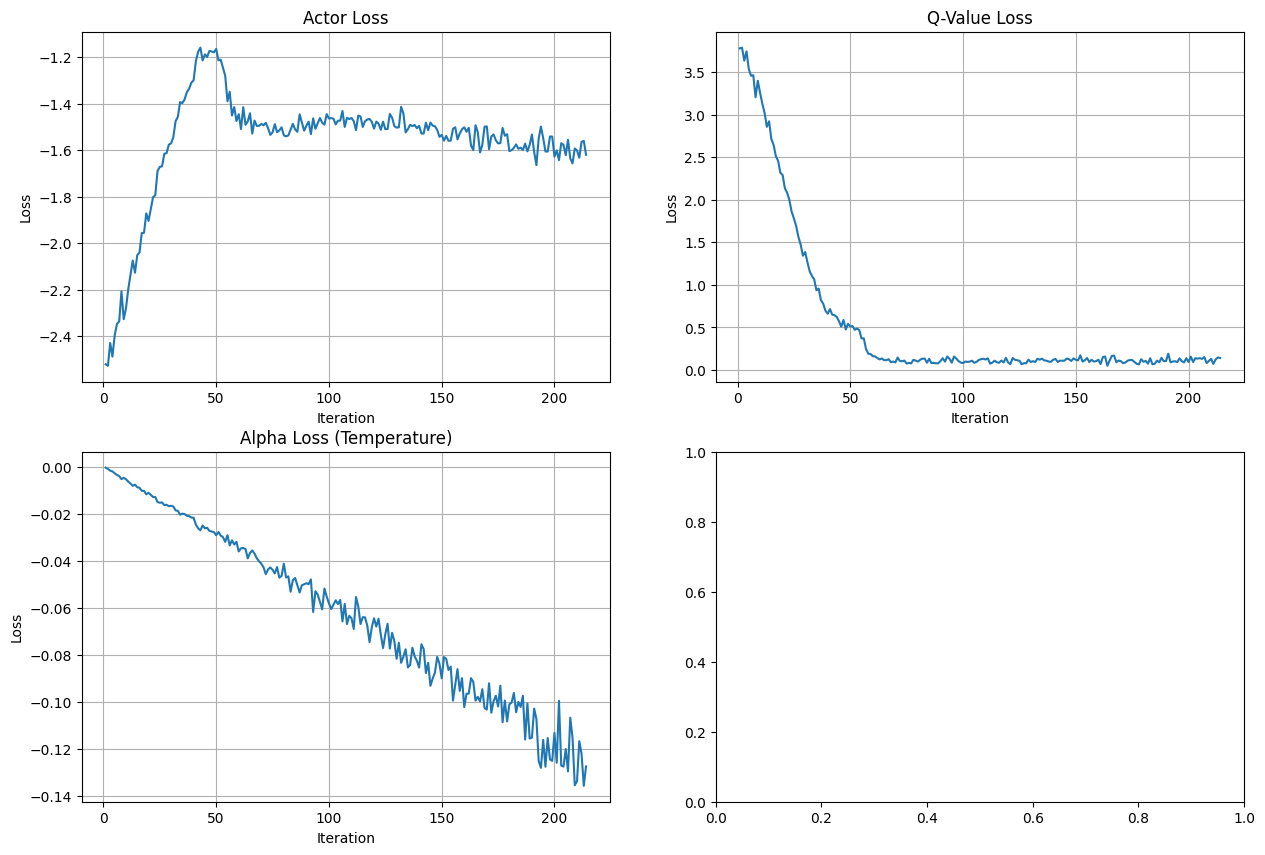

In [17]:
import matplotlib.pyplot as plt

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Actor Loss
axes[0, 0].plot(training_history['iteration'], training_history['actor_loss'])
axes[0, 0].set_title('Actor Loss')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True)

# QValue Loss
axes[0, 1].plot(training_history['iteration'], training_history['qvalue_loss'])
axes[0, 1].set_title('Q-Value Loss')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True)

# Alpha Loss
axes[1, 0].plot(training_history['iteration'], training_history['alpha_loss'])
axes[1, 0].set_title('Alpha Loss (Temperature)')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True)

# Win Rate
eval_iterations = [training_history['iteration'][i] for i in range(0, len(training_history['iteration']), LOG_INTERVAL)]
axes[1, 1].plot(eval_iterations, training_history['win_rate'], marker='o')
axes[1, 1].axhline(y=0.5, color='r', linestyle='--', label='Random Baseline')
axes[1, 1].set_title('Win Rate vs Random Policy')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Win Rate')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(f'd:/Code/Python/hex-irl/results/training_curves_{BOARD_SIZE}x{BOARD_SIZE}.png', dpi=300)
plt.show()

print("Training curves saved!")

In [ ]:
print("=" * 50)
print("FINAL EVALUATION - 100 Games")
print("=" * 50)

final_eval = evaluate_agent(actor, serial_env, n_games=100, device=DEVICE)

print(f"\nFinal Results:")
print(f"  Total Win Rate: {final_eval['win_rate']:.1%}")
print(f"  Wins as Player 0 (Red): {final_eval['wins_as_p0']}/{final_eval['games_as_p0']} "
      f"({final_eval['wins_as_p0']/final_eval['games_as_p0']:.1%})")
print(f"  Wins as Player 1 (Blue): {final_eval['wins_as_p1']}/{final_eval['games_as_p1']} "
      f"({final_eval['wins_as_p1']/final_eval['games_as_p1']:.1%})")
# print(f"\nBest Win Rate During Training: {best_win_rate:.1%}")
print("=" * 50)

FINAL EVALUATION - 100 Games

Final Results:
  Total Win Rate: 94.0%
  Wins as Player 0 (Red): 48/50 (96.0%)
  Wins as Player 1 (Blue): 46/50 (92.0%)


In [ ]:
import torch

def check_actor_params_validity(actor):
    """
    Check if actor parameters contain valid real numbers (not NaN or Inf).
    
    Returns:
        dict with detailed information about parameter validity
    """
    results = {
        'all_valid': True,
        'total_params': 0,
        'nan_params': [],
        'inf_params': [],
        'valid_params': 0
    }
    
    print("=" * 60)
    print("Checking Actor Parameters Validity")
    print("=" * 60)
    
    for name, param in actor.named_parameters():
        if param.requires_grad:
            results['total_params'] += 1
            
            # Check for NaN
            has_nan = torch.isnan(param).any().item()
            # Check for Inf
            has_inf = torch.isinf(param).any().item()
            
            if has_nan:
                results['all_valid'] = False
                results['nan_params'].append(name)
                print(f"❌ {name}: Contains NaN values")
                print(f"   Shape: {param.shape}, NaN count: {torch.isnan(param).sum().item()}")
            
            if has_inf:
                results['all_valid'] = False
                results['inf_params'].append(name)
                print(f"❌ {name}: Contains Inf values")
                print(f"   Shape: {param.shape}, Inf count: {torch.isinf(param).sum().item()}")
            
            if not has_nan and not has_inf:
                results['valid_params'] += 1
                # Optional: print min/max for valid params
                print(f"✓ {name}: Valid - min={param.min().item():.6f}, max={param.max().item():.6f}")
    
    print("\n" + "=" * 60)
    print("Summary:")
    print(f"  Total parameters: {results['total_params']}")
    print(f"  Valid parameters: {results['valid_params']}")
    print(f"  Parameters with NaN: {len(results['nan_params'])}")
    print(f"  Parameters with Inf: {len(results['inf_params'])}")
    
    if results['all_valid']:
        print("\n✅ All actor parameters are valid!")
    else:
        print("\n❌ Some actor parameters contain invalid values!")
        if results['nan_params']:
            print(f"\nNaN in: {results['nan_params']}")
        if results['inf_params']:
            print(f"\nInf in: {results['inf_params']}")
    
    print("=" * 60)
    
    return results

# Run the check
validity_results = check_actor_params_validity(actor)

Checking Actor Parameters Validity
✓ module.0.module.model.conv.0.adjust_input.0.conv.weight: Valid - min=-0.681706, max=0.801933
✓ module.0.module.model.conv.0.adjust_input.1.weight: Valid - min=0.942665, max=1.063240
✓ module.0.module.model.conv.0.adjust_input.1.bias: Valid - min=-0.018415, max=0.055370
✓ module.0.module.model.conv.0.adjust_input.3.conv.weight: Valid - min=-0.295153, max=0.350219
✓ module.0.module.model.conv.0.adjust_input.4.weight: Valid - min=0.909890, max=1.042353
✓ module.0.module.model.conv.0.adjust_input.4.bias: Valid - min=-0.038754, max=0.021844
✓ module.0.module.model.conv.0.original_input.0.weight: Valid - min=-0.647249, max=0.604259
✓ module.0.module.model.conv.0.original_input.0.bias: Valid - min=-0.031745, max=0.048193
✓ module.0.module.model.conv.0.original_input.1.weight: Valid - min=0.953714, max=1.070481
✓ module.0.module.model.conv.0.original_input.1.bias: Valid - min=-0.038754, max=0.021844
✓ module.0.module.model.encoder.layers.0.self_attn.in_proj

In [ ]:
# Set all actor parameters to zero
with torch.no_grad():
    for param in actor.parameters():
        param.zero_()

print("✓ All actor parameters have been set to zeros")

# Verify the change
print("\nVerifying parameters are zeros:")
all_zeros = True
for name, param in actor.named_parameters():
    if param.abs().sum().item() > 0:
        all_zeros = False
        print(f"❌ {name}: NOT zero (sum of abs values: {param.abs().sum().item()})")
    else:
        print(f"✓ {name}: All zeros")

if all_zeros:
    print("\n✅ All actor parameters are successfully set to zeros!")
else:
    print("\n⚠️ Some parameters are not zeros!")

✓ All actor parameters have been set to zeros

Verifying parameters are zeros:
✓ module.0.module.model.conv.0.adjust_input.0.conv.weight: All zeros
✓ module.0.module.model.conv.0.adjust_input.1.weight: All zeros
✓ module.0.module.model.conv.0.adjust_input.1.bias: All zeros
✓ module.0.module.model.conv.0.adjust_input.3.conv.weight: All zeros
✓ module.0.module.model.conv.0.adjust_input.4.weight: All zeros
✓ module.0.module.model.conv.0.adjust_input.4.bias: All zeros
✓ module.0.module.model.conv.0.original_input.0.weight: All zeros
✓ module.0.module.model.conv.0.original_input.0.bias: All zeros
✓ module.0.module.model.conv.0.original_input.1.weight: All zeros
✓ module.0.module.model.conv.0.original_input.1.bias: All zeros
✓ module.0.module.model.encoder.layers.0.self_attn.in_proj_weight: All zeros
✓ module.0.module.model.encoder.layers.0.self_attn.in_proj_bias: All zeros
✓ module.0.module.model.encoder.layers.0.self_attn.out_proj.weight: All zeros
✓ module.0.module.model.encoder.layers.0.